In [141]:
# Import files
import numpy as np
import pandas as pd 

In [142]:
credits=pd.read_csv("./tmdb_5000_credits.csv")
movies=pd.read_csv("./tmdb_5000_movies.csv")

In [143]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [144]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [145]:
movies = movies.merge(credits,on="title")
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


Testing various parameters that we will use for content based filtering

# Demographic Filtering 
Before getting started with this -


1) We need a metric to score or rate a movie
2) Calculate the score for every movie
2) Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

<img src="./Explanations/weighted_formula_DF.png" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">


where,

- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; And
- C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [146]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [147]:
C=movies['vote_average'].mean()
C

np.float64(6.092514036182159)

In [148]:
m=movies['vote_count'].quantile(0.85)
m

np.float64(1302.5999999999995)

In [149]:
q_movies=movies.copy().loc[movies['vote_count']>=m]
q_movies.shape

(722, 23)

In [150]:
def weighted_rating(x,m=m,C=C):
    v=x['vote_count']
    R=x['vote_average']
    
    # IMDB Score
    return (v/(v+m)*R) + (m/(v+m)*C)
    

In [151]:
q_movies['score']=q_movies.apply(weighted_rating, axis=1)

In [152]:
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
1883,The Shawshank Redemption,8205,8.5,8.170160
662,Fight Club,9413,8.3,8.031656
3235,Pulp Fiction,8428,8.3,8.004492
65,The Dark Knight,12002,8.2,7.993665
3340,The Godfather,5893,8.4,7.982282
96,Inception,13752,8.1,7.926302
809,Forrest Gump,7927,8.2,7.902564
95,Interstellar,10867,8.1,7.885124
329,The Lord of the Rings: The Return of the King,8064,8.1,7.820822
1992,The Empire Strikes Back,5879,8.2,7.817744


Popularity Plot

Text(0.5, 1.0, 'Popular Movies')

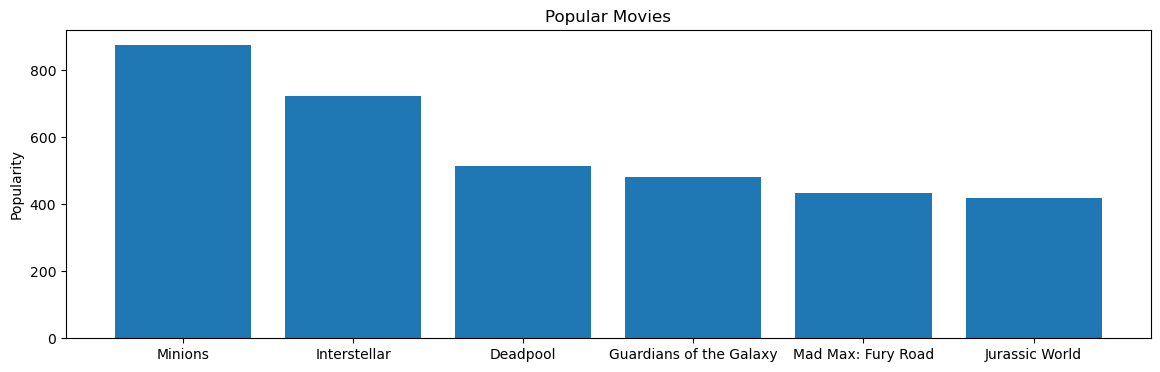

In [153]:
from matplotlib import pyplot as plt

pop = movies.sort_values('popularity', ascending=False)

plt.figure(figsize=(14,4))
plt.bar(pop['title'].head(6), pop['popularity'].head(6), align="center")
plt.ylabel('Popularity')
plt.title("Popular Movies")

# Content Based Filtering

In [154]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [155]:
# movies['keywords'].values
movies['original_language'].value_counts()

original_language
en    4510
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
ko      12
cn      12
ru      11
pt       9
da       7
sv       5
nl       4
fa       4
th       3
he       3
ta       2
cs       2
ro       2
id       2
ar       2
vi       1
sl       1
ps       1
no       1
ky       1
hu       1
pl       1
af       1
nb       1
tr       1
is       1
xx       1
te       1
el       1
Name: count, dtype: int64

In [156]:
# Features Req
# genres , id, keywords, title, overview, cast, crew

movies = movies[['id', 'genres', 'keywords', 'title', 'overview', 'cast', 'crew']]

In [157]:
movies.head(10)

,id,genres,keywords,title,overview,cast,crew
0,19995,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",Spectre,A cryptic message from Bond’s past sends him o...,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",John Carter,"John Carter is a war-weary, former military ca...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,559,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,38757,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...","[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",Tangled,When the kingdom's most wanted-and most charmi...,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de..."
7,99861,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,"[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de..."
8,767,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""n...",Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...","[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de..."
9,209112,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 7002...",Batman v Superman: Dawn of Justice,Fearing the actions of a god-like Super Hero l...,"[{""cast_id"": 18, ""character"": ""Bruce Wayne / B...","[{""credit_id"": ""553bf23692514135c8002886"", ""de..."


In [158]:
movies.isnull().sum()

id          0
genres      0
keywords    0
title       0
overview    3
cast        0
crew        0
dtype: int64

In [159]:
movies.dropna(inplace=True)
movies.shape

(4806, 7)

In [160]:
movies.duplicated().sum()

np.int64(0)

In [161]:
movies.head(1)

,id,genres,keywords,title,overview,cast,crew
0,19995,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [162]:
import ast
def convert(obj):
    L=[]
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    
    return L
        

In [163]:
movies['genres'] = movies['genres'].apply(convert)

In [164]:
movies['keywords'] = movies['keywords'].apply(convert)

In [165]:
def convert3(obj):
    L=[]
    cnt=0;
    for i in ast.literal_eval(obj):
        if cnt < 3 :
            L.append(i['name'])
        else : break
        
        cnt+=1
    
    return L

In [166]:
movies['cast'] = movies['cast'].apply(convert3)

In [167]:
movies['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [168]:
def fetch_director(obj):
    L=[]
    cnt=0;
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    
    return L

In [169]:
movies['crew'] = movies['crew'].apply(fetch_director)

In [170]:
movies['overview'] = movies['overview'].apply(lambda x: x.split())

In [171]:
# Transformation to remove spaces in 1 name
movies['genres']= movies['genres'].apply(lambda x: [i.replace(" ","") for i in x])
movies['keywords']= movies['keywords'].apply(lambda x: [i.replace(" ","") for i in x])
movies['cast']= movies['cast'].apply(lambda x: [i.replace(" ","") for i in x])
movies['crew']= movies['crew'].apply(lambda x: [i.replace(" ","") for i in x])

In [172]:
movies.head(4)

,id,genres,keywords,title,overview,cast,crew
0,19995,"[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...",Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,"[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...",Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,"[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...",Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,"[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...",The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]


In [175]:
movies['tags']= movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew'] + movies['overview']

In [174]:
new_df=movies[['id', 'title', 'tags']]

In [177]:
new_df['tags'] = new_df['tags'].apply( lambda x: " ".join(x))

/var/folders/gy/8kyyh3293k791qbjt3p7ymg80000gn/T/ipykernel_31693/878900215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply( lambda x: " ".join(x))


In [179]:
new_df['tags'] = new_df['tags'].apply( lambda x: x.lower())

/var/folders/gy/8kyyh3293k791qbjt3p7ymg80000gn/T/ipykernel_31693/4280047530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply( lambda x: x.lower())


In [180]:
new_df.head(5)

,id,title,tags
0,19995,Avatar,action adventure fantasy sciencefiction cultur...
1,285,Pirates of the Caribbean: At World's End,adventure fantasy action ocean drugabuse exoti...
2,206647,Spectre,action adventure crime spy basedonnovel secret...
3,49026,The Dark Knight Rises,action crime drama thriller dccomics crimefigh...
4,49529,John Carter,action adventure sciencefiction basedonnovel m...


In [181]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer(max_features=5000, stop_words='english')

In [182]:
vectors=cv.fit_transform(new_df['tags']).toarray()
vectors.shape

(4806, 5000)

In [183]:
cv.get_feature_names_out()
# len(cv.get_feature_names_out())


array(['000', '007', '10', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

In [184]:
# %pip install nltk
import nltk

AttributeError: partially initialized module 'nltk' has no attribute 'data' (most likely due to a circular import)

In [185]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [186]:
def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    
    return " ".join(y)

In [187]:
stem('activities activity hello activist')

'activ activ hello activist'

In [188]:
new_df['tags'] = new_df['tags'].apply(stem)

/var/folders/gy/8kyyh3293k791qbjt3p7ymg80000gn/T/ipykernel_31693/3213734980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(stem)


In [189]:
vectors=cv.fit_transform(new_df['tags']).toarray()
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [190]:
cv.get_feature_names_out()

array(['000', '007', '10', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

Finding the Cosine distance between vectors 

Distance is inversely proportional to Similarity

NOTE: Eucledian distance doesnt give accurate results in higher dimension , due to Curse of Dimensionality

In [192]:
# Calcualte cosine similarity for each movie with each movie 
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity(vectors).shape
# vectors.shape

(4806, 4806)

In [ ]:
similarity = cosine_similarity(vectors)

In [204]:
similarity

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

In [203]:
movie_index=new_df[new_df['title']=='Batman Begins'].index[0]
movie_index

np.int64(119)

In [211]:
# for the first movie similarity array is
distances = similarity[0]

# 1) enumerate all the movies which makes a tuple of (index, distance from that movie), so we dont lose the index 
enumerate(distances)

# 2) reverse sort it based on the distance and show top 5 movies
sorted(list(enumerate(distances)), reverse=True, key = lambda x : x[1])[1:6]

[(1214, np.float64(0.28676966733820225)),
 (2405, np.float64(0.26901379342448517)),
 (3728, np.float64(0.2605130246476754)),
 (507, np.float64(0.255608593705383)),
 (539, np.float64(0.25038669783359574))]

In [223]:
def recommend(movie):
    movie_index = new_df[new_df['title']==movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key = lambda x : x[1])[1:6]
    
    for i in movies_list:
        print(new_df.iloc[i[0]]['title'])

In [224]:
recommend('Batman Begins')

The Dark Knight
Batman
Batman
The Dark Knight Rises
10th & Wolf


In [231]:
import pickle
import bz2file as bz2

In [236]:
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'wb') as f:
        pickle.dump(data, f)

In [237]:
compressed_pickle('movies_list', new_df)

In [238]:
compressed_pickle('similarity', similarity)

In [ ]:
pickle.dump(new_df, open('movies_list.pkl','wb'))

In [ ]:
pickle.dump(similarity, open('similarity.pkl','wb'))